In [2]:
import sys
import numpy as np
from graphviz import Digraph, Source
from pathlib import Path
from pynini import Weight

sys.path.append(str(Path.home() / 'Code/Python/wynini'))
from wynini import config as wconfig
from wynini import wfst
from wynini.wfst import *

#help(wconfig)
wconfig.init()

In [7]:
help(wconfig)

Help on module wynini.config in wynini:

NAME
    wynini.config

FUNCTIONS
    init(config={})
        Set globals with dictionary or module

    make_symtable(sigma)

DATA
    bos = '⋊'
    eos = '⋉'
    epsilon = 'ϵ'
    sigma = ['a', 'b']
    special_syms = []
    syms = ['ϵ', '⋊', '⋉', 'a', 'b']
    symtable = <SymbolTable '<unspecified>'>
    unk = '⊥'
    verbosity = 0
    λ = ''

FILE
    /home/colin/Code/Python/wynini/wynini/config.py




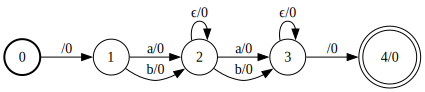

In [3]:
M = braid(2, arc_type='log')
one = Weight('log', 0.0)
M.assign_weights(lambda M, q, t: one)

#M = trellis(2)
#M = ngram(context='left', length=1)
M.draw('M.dot', show_weight_one=True)
M_viz = Source.from_file('M.dot')
M_viz

In [4]:
beta = shortestdistance(M, reverse=True)
beta = np.array([float(w) for w in beta])
print(np.exp(-beta))

[2.44335813e+11 2.44335813e+11 2.44335813e+11 6.99050665e+05
 1.00000000e+00]
